In [1]:
import os
import shutil
import yaml

import torch
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import argparse
import re

from src.utils.helpers import makedir
from src.models import seg_model
from src.training import push
from src.training import prune
from src.training import train_and_test as tnt

from src.utils import save
from src.utils.log import create_logger
import logging
from src.data.raman_dataset import create_raman_mask_dataloaders_from_ids

import matplotlib.pyplot as plt

In [2]:
logging.basicConfig(level=logging.INFO)

In [3]:
model_path = "out_model/saved_models/resnet34/15/10_4push0.7949.pth"
# load the model
model = torch.load(model_path)
model

/tmp/ipykernel_3872683/1025654392.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


PPNet(
	features: resnet34_features,
	img_size: 256,
	prototype_shape: (20, 256, 1, 1),
	proto_layer_rf_info: [8, 32, 899, 0.5],
	num_classes: 2,
	epsilon: 0.0001
)

In [4]:
# config for training
config_file = "./configs/unet_segment_newdata.yaml"
with open(config_file, "r") as stream:
    conf = yaml.safe_load(stream)

# Check generation

In [6]:
raman_id = ['E919-24_sample1_1']
val_dl = create_raman_mask_dataloaders_from_ids(
    raman_id,
    conf,
    shuffle=False,
    in_memory=True,
    is_train=False,
)

INFO:root:Creating Raman/Mask data loader for IDs: ['E919-24_sample1_1']
INFO:root:InMemoryRamanMaskData: conf_data={'train_ids': ['E12198-23_sample1_half1', 'E12198-23_sample1_half2', 'E12198-23_sample2_half1', 'E12198-23_sample2_half2', 'E1223-24_sample1', 'E1223-24_sample2', 'E1223-24_sample3', 'E13557-23_half1', 'E13557-23_half2', 'E15356-23_sample1', 'E15356-23_sample2', 'E15356-23_sample3', 'E15356-23_sample4', 'E15754-23_sample1', 'E15754-23_sample2', 'E15754-23_sample3', 'E17878-23_sample1_half1', 'E17878-23_sample1_half2', 'E17878-23_sample2_half1'], 'val_ids': ['E919-24_sample1_1', 'E919-24_sample1_2', 'E919-24_sample2_1', 'E919-24_sample2_2'], 'acdc_channels': [3, 26], 'use_srs_norm': True, 'extra_filtering': []}, conf_train={'patch_size': [256, 256], 'stride': [256, 256]}, wandb_conf=None
INFO:root:Final Raman shape: torch.Size([282, 24, 256, 256])


input shape: torch.Size([36, 24, 256, 256])
target shape: torch.Size([36, 256, 256])
output shape: torch.Size([36, 256, 256])


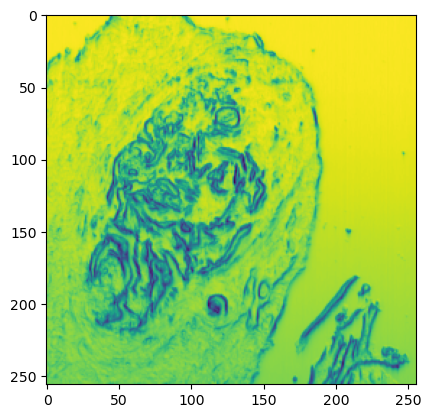

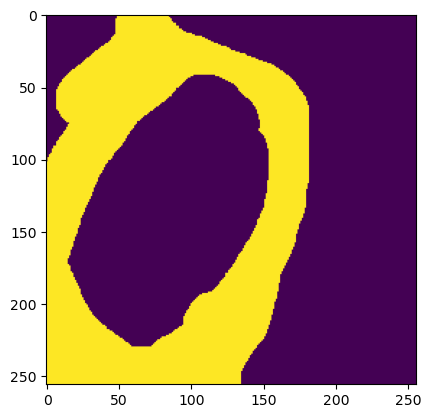

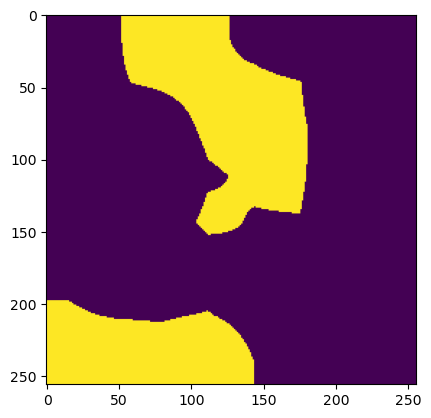

In [16]:
for i, (img, mask) in enumerate(val_dl):
    batch_i = 8
    if mask[batch_i].sum() < 50:
        continue

    input = img.cuda()
    target = mask.cuda()
    target = target.squeeze(1).long()

    with torch.inference_mode():
        output, _ = model(input)
        output = torch.argmax(output, dim=1)

    print(f"input shape: {input.shape}")
    print(f"target shape: {target.shape}")
    print(f"output shape: {output.shape}")

    plt.imshow(input[batch_i, 21].cpu().numpy())
    plt.show()
    plt.imshow(target[batch_i].cpu().numpy())
    plt.show()
    plt.imshow(output[batch_i].cpu().numpy())
    plt.show()
    break